In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(r"C:\Users\marku\Documents\SteelProdData_Project\src\scripts")

In [2]:
train_data_orig = pd.read_csv('C:\\Users\\marku\\Documents\\SteelProdData_Project\\data\\raw\\normalized_train_data.csv')
test_data_orig = pd.read_csv('C:\\Users\\marku\\Documents\\SteelProdData_Project\\data\\raw\\normalized_test_data.csv')


In [3]:
conc_data=pd.concat([train_data_orig, test_data_orig], ignore_index=True)

In [ ]:
#Check for missing values

# Define a set of values that should be treated as empty/missing
EMPTY_TOKENS = {"", " ", "NA", "N/A", "null", "None", "nan", "-"}

# Create a copy of the dataframe to avoid modifying the original
conc_data_check = conc_data.copy()

# Convert empty strings and placeholder values to NaN in object columns
obj_cols = conc_data_check.select_dtypes(include=["object"]).columns
for c in obj_cols:
    conc_data_check[c] = (
        conc_data_check[c]
        .astype(str)        # Convert all values to strings
        .str.strip()        # Remove leading/trailing whitespace
        .replace(EMPTY_TOKENS, np.nan)  # Replace empty tokens with NaN
    )

# Create a summary dataframe with statistics about each column
summary = pd.DataFrame({
    "dtype": conc_data_check.dtypes.astype(str),      # Data type of each column
    "rows_total": len(conc_data_check),               # Total number of rows
    "non_null": conc_data_check.notna().sum(),        # Count of non-null values
    "nulls": conc_data_check.isna().sum(),            # Count of null values
    "null_frac": (conc_data_check.isna().mean()),     # n_NaN/n_all_Entries
    "n_unique": conc_data_check.nunique(dropna=True), # Count of unique non-null values
})
# Sort the summary by null fraction
summary = summary.sort_values("null_frac", ascending=False)


display(summary)

In [ ]:
#Replace missing values with mean of the columns -Not necessary
numerical_cols = conc_data.select_dtypes(include=np.number).columns.tolist() 
conc_data[numerical_cols] = conc_data[numerical_cols].apply(lambda x: x.fillna(x.mean()), axis=0) # Fill NaN with column mean

In [ ]:
#Check for duplicates

# Count duplicate rows based on all input and output columns
n_dup = conc_data_check.duplicated().sum()
print(f"Duplikate über input1..input21 + output: {n_dup}")

# Display duplicate rows
dup_rows = conc_data_check[conc_data_check.duplicated(keep=False)].copy()

display(dup_rows.head(5))  # Display first 5 duplicate rows


In [ ]:
plt.hist(train_data_orig["output"])
plt.hist(test_data_orig["output"])
plt.xlabel('Output')
plt.ylabel('n') 
plt.title('Distribution of Output')
plt.show()

In [ ]:
import seaborn as sns

g=sns.pairplot(conc_data.sample(n=300, random_state=42)) #Plot pairwise relationships with sample of 300 rows

In [ ]:
#Heatmap

num_cols = conc_data.select_dtypes(include=["number"]).columns.tolist()
num_cols.remove("output")                             #Remove column output from correlation analysis


corr_cols = num_cols[:] 
corr = conc_data[corr_cols].corr()  
plt.figure(figsize=(10, 8))
plt.imshow(corr.values, aspect="auto")
plt.title("Korrelation")
plt.colorbar()

plt.xticks(range(len(corr_cols)), corr_cols, rotation=90, fontsize=8)
plt.yticks(range(len(corr_cols)), corr_cols, fontsize=8)

plt.tight_layout()
plt.show()

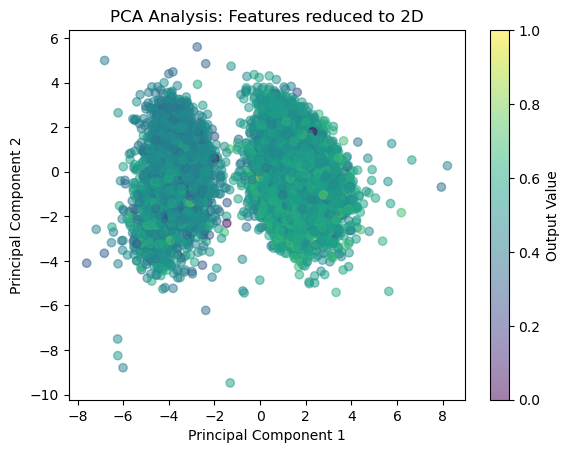

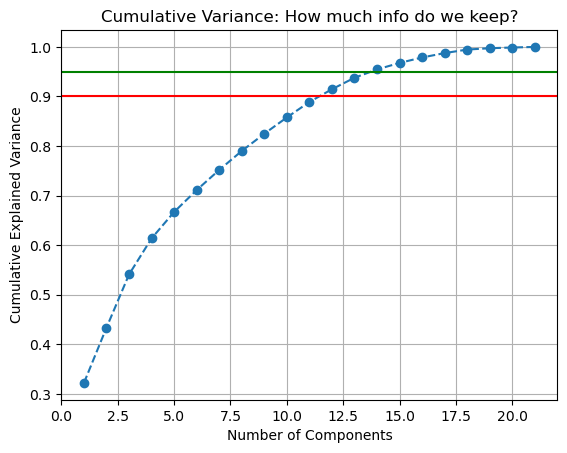

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X=conc_data.drop("output" , axis=1 ).values
y=conc_data["output"].values

# Standardize the inputs (PCA works best when data is centered)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce the 21 features down to just 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_2=PCA() #For plotting cumulative variance
pca_2.fit(X_scaled)

# Create the scatter plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.colorbar(label='Output Value')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Analysis: Features reduced to 2D')
plt.show()

cumulative_variance=np.cumsum(pca_2.explained_variance_ratio_)

plt.plot(range(1,22),cumulative_variance, marker='o', linestyle='--')

plt.axhline(y=0.90, color='r', linestyle='-', label='90% Variance')
plt.axhline(y=0.95, color='g', linestyle='-', label='95% Variance')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance: How much info do we keep?')
plt.grid(True)
plt.show()

In [5]:
#Test/Train_Split
X=conc_data.drop("output" , axis=1 ).values
y=conc_data["output"].values


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=35)


In [6]:
#Establish Baseline Model with Linear Regression

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
#s=StandardScaler()       #Data is standardized using Min-Max Scaling
#s.fit(X_train) 

#X_train_trans= s.transform(X_train) 
#X_test_trans=s.transform(X_test)

model_lr=LinearRegression()

model_lr.fit(X_train, y_train)

print(model_lr.score(X_test,y_test))

0.25844371216463946


In [ ]:
#RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor()

model.fit(X_train, y_train)

print(model.score(X_test,y_test))

In [ ]:
#Standard Gaussian Process (RBF and COnstant Kernel)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Define the kernel (covariance function)
# Here we use a constant kernel multiplied by an RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
model_gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1)
model_gp.fit(X_train, y_train)

from plot_helper import evaluate_model, plot_data
evaluate_model(model_gp, X_test, y_test)
plot_data(X_test, y_test, model_gp.predict(X_test), title="Model Predictions vs Ground Truth on Test Data")

In [ ]:
#Standard Gaussian Process (RBF and COnstant Kernel)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, DotProduct, WhiteKernel, ConstantKernel

# Define the kernel (covariance function)

kernel = (ConstantKernel(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0]*21, nu=1.5) + 
    DotProduct(sigma_0=1.0) + 
    WhiteKernel(noise_level=0.1)
)
model_gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1)
model_gp.fit(X_train, y_train)

from plot_helper import evaluate_model, plot_data
evaluate_model(model_gp, X_test, y_test)
plot_data(X_test, y_test, model_gp.predict(X_test), title="Model Predictions vs Ground Truth on Test Data")

In [28]:
from keras.models import Sequential
from keras.layers import Dense  

model_dnnstd = Sequential()
model_dnnstd.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],) )) #21 Inputs
model_dnnstd.add(Dense(1,activation='linear'))

model_dnnstd.compile(optimizer='adam', loss='mse', metrics=['mae'])


history_dnnstd=model_dnnstd.fit(
          X_train,
          y_train,
          epochs=100,
          batch_size=32)



Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - loss: 0.0111 - mae: 0.0777
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.0075 - mae: 0.0669
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 0.0073 - mae: 0.0664
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 0.0070 - mae: 0.0653
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 0.0071 - mae: 0.0659
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 0.0068 - mae: 0.0643
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 0.0067 - mae: 0.0638
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 0.0065 - mae: 0.0628
Epoch 9/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 0.0063 - mae: 0.0621
Epoch 10/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 0.0063 - mae: 0.0619
Epoch 11/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 0.0062 - mae: 0.0615
Epoch 12/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 0.0060 - m

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
model_dnnopt = models.Sequential()
model_dnnopt.add(Dense(512, activation='relu', input_shape=(21,),kernel_regularizer=regularizers.l2(1e-4))) #21 Inputs
model_dnnopt.add(layers.BatchNormalization())


model_dnnopt.add(Dense(256, activation='relu'))
model_dnnopt.add(layers.Dropout(0.3))
model_dnnopt.add(Dense(128, activation='relu'))
model_dnnopt.add(layers.BatchNormalization())

model_dnnopt.add(Dense(64, activation='relu'))
model_dnnopt.add(Dense(64, activation='relu'))
model_dnnopt.add(Dense(1,activation='linear'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_dnnopt.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae','mse'])




In [30]:
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,    # Cut LR by 80% when progress stalls
    patience=5, 
    min_lr=1e-7,
    verbose=1
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=12, 
    restore_best_weights=True
)


history_dnnopt = model_dnnopt.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,          # Increased epochs to allow LR scheduler to work
    batch_size=32,      
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


Epoch 1/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0227 - mae: 0.1392 - mse: 0.0395 - val_loss: 0.0153 - val_mae: 0.1302 - val_mse: 0.0246 - learning_rate: 0.0010
Epoch 2/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0089 - mae: 0.0853 - mse: 0.0119 - val_loss: 0.0092 - val_mae: 0.0872 - val_mse: 0.0127 - learning_rate: 0.0010
Epoch 3/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0076 - mae: 0.0770 - mse: 0.0096 - val_loss: 0.0065 - val_mae: 0.0655 - val_mse: 0.0076 - learning_rate: 0.0010
Epoch 4/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0708 - mse: 0.0082 - val_loss: 0.0058 - val_mae: 0.0609 - val_mse: 0.0067 - learning_rate: 0.0010
Epoch 5/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061 - mae: 0.0677 - mse: 0.0075 - val_loss: 0.0065 - val_mae: 0.0727 - val_mse: 0.0084 - learning_rate: 0.0010
Epoch 6/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0057 - mae: 0.0658 - mse: 0.0071 - val_loss: 0.0052 - val_mae:

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Evaluation Metrics
     Metric     Value
0  R² Score  0.321899
1      RMSE  0.078280
2       MAE  0.058137
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step


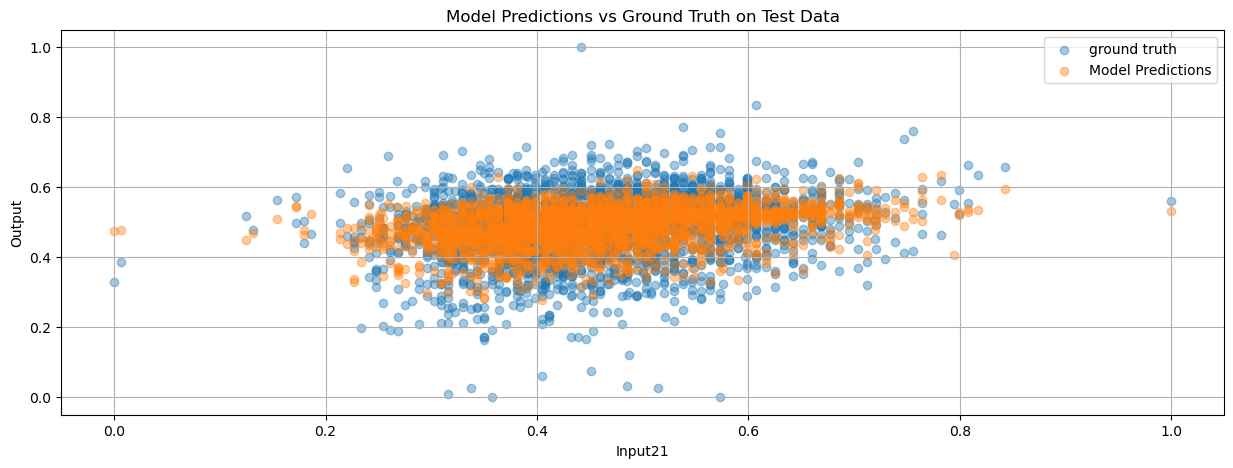

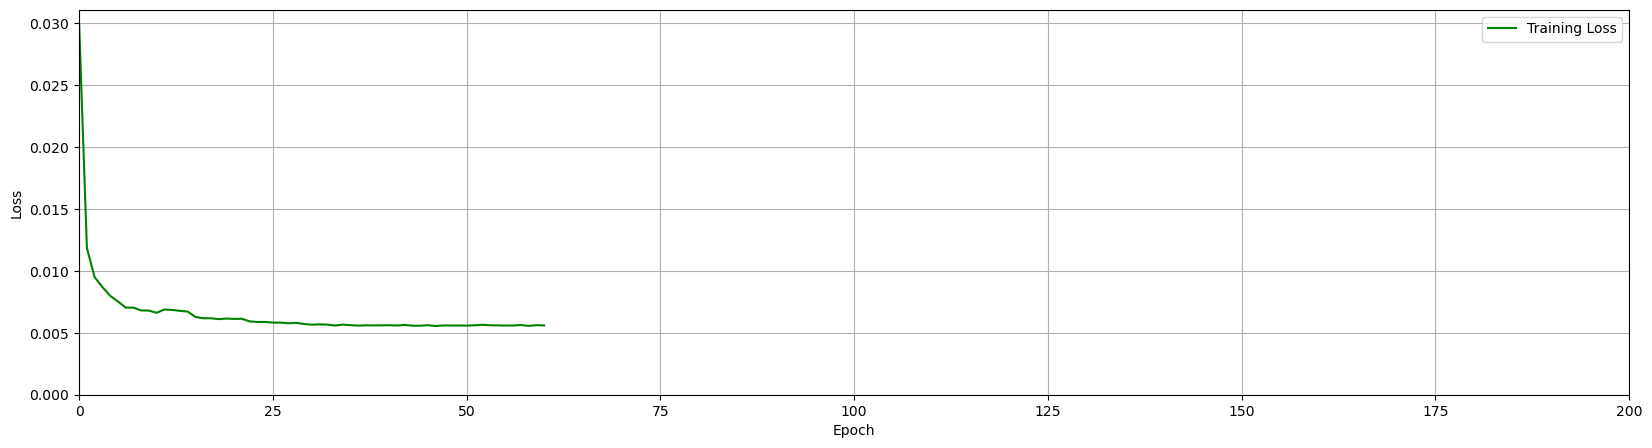

In [22]:
from plot_helper import evaluate_model, plot_data, plot_loss
evaluate_model(model_dnnopt, X_test_pca, y_test)
plot_data(X_test, y_test, model_dnnopt.predict(X_test_pca), title="Model Predictions vs Ground Truth on Test Data")
plot_loss(history_dnnopt)

Model Evaluation Metrics
     Metric     Value
0  R² Score  0.258444
1      RMSE  0.081861
2       MAE  0.061824


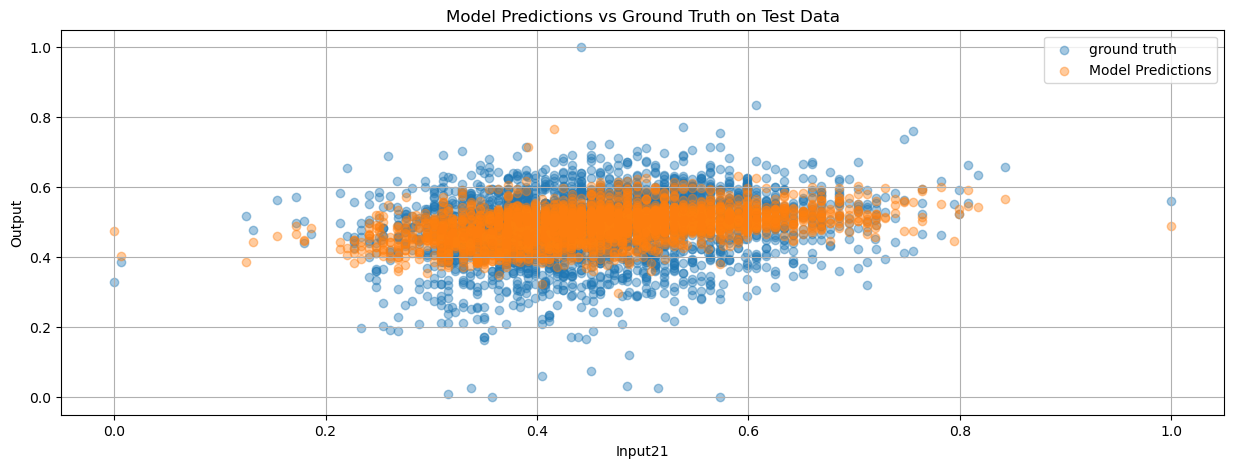

In [7]:
#Eval linear regression

from plot_helper import evaluate_model, plot_data
evaluate_model(model_lr, X_test, y_test)
plot_data(X_test, y_test, model_lr.predict(X_test), title="Model Predictions vs Ground Truth on Test Data")

In [ ]:
#Eval RFRegressor

from plot_helper import evaluate_model, plot_data
evaluate_model(model_rfreg, X_test, y_test)
plot_data(X_test, y_test, model_rfreg.predict(X_test), title="Model Predictions vs Ground Truth on Test Data")

In [ ]:
#Eval DNN standard

from plot_helper import evaluate_model, plot_data
evaluate_model(model_dnnstd, X_test, y_test)
plot_data(X_test, y_test, model_dnnstd.predict(X_test), title="Model Predictions vs Ground Truth on Test Data")
plot_loss(history_dnnstd)

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Evaluation Metrics
     Metric     Value
0  R² Score  0.419686
1      RMSE  0.072416
2       MAE  0.053200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step


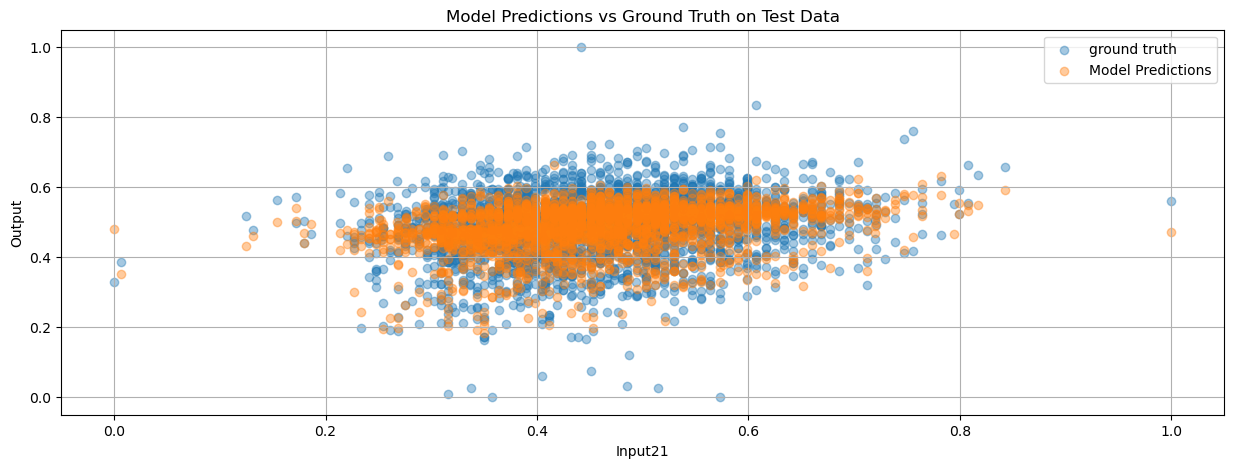

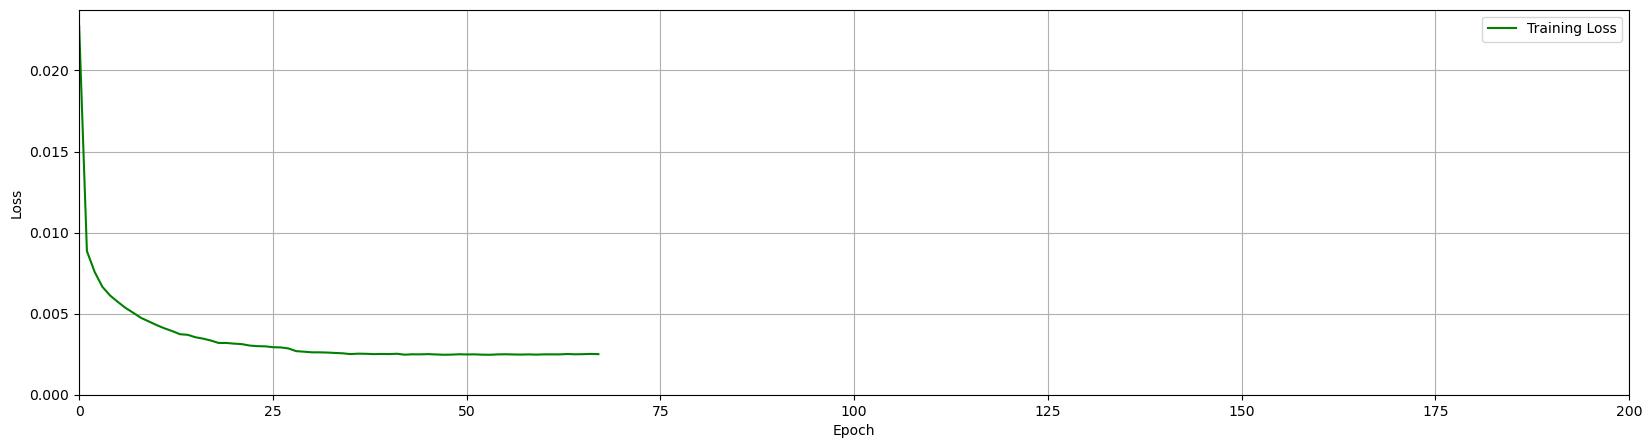

In [31]:
#Eval DNN optimized

from plot_helper import evaluate_model, plot_data
evaluate_model(model_dnnopt, X_test, y_test)
plot_data(X_test, y_test, model_dnnopt.predict(X_test), title="Model Predictions vs Ground Truth on Test Data")
plot_loss(history_dnnopt)

In [ ]:
#Eval All Models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# 1. Calculate Baseline R2
y_pred = model.predict(X_test).flatten()
baseline_r2 = r2_score(y_test, y_pred)
print(f"Baseline R2: {baseline_r2:.4f}")

# 2. Permutation Importance
feature_importance = []
features = [f'input{i+1}' for i in range(21)]

for i in range(X_test.shape[1]):
    save_col = X_test[:, i].copy()
    # Scramble one feature
    np.random.shuffle(X_test[:, i])
    # Predict with scrambled data
    shuff_pred = model.predict(X_test, verbose=0).flatten()
    shuff_r2 = r2_score(y_test, shuff_pred)
    # Restore the column
    X_test[:, i] = save_col
    # Importance is how much the score dropped
    feature_importance.append(baseline_r2 - shuff_r2)

# 3. Plotting Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(features, feature_importance, color='skyblue')
plt.xticks(rotation=90)
plt.title("Feature Importance (Drop in R2)")
plt.ylabel("Importance Score")
plt.show()

# 4. Actual vs Predicted Scatter
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.3, color='orange')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction Accuracy (Discrete Steps)")
plt.show()